In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

import numpy as np

In [4]:
import tensorflow as tf


In [5]:
from tf_fourier_features import FourierFeatureProjection

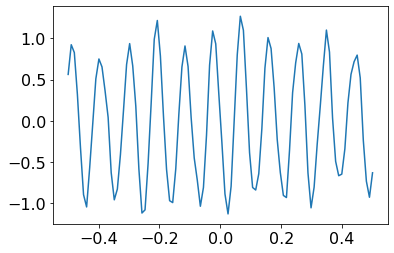

In [791]:
model_test = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    FourierFeatureProjection(gaussian_projection = 5, gaussian_scale = 12),
    # tf.keras.layers.Dense(12),
    # tf.keras.layers.Dense(12),
    # tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dense(2, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=np.random.randint(1000))),
    # tf.keras.layers.Dense(2, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=np.random.randint(1000))),
    # tf.keras.layers.Dense(2, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=np.random.randint(1000))),
    tf.keras.layers.Dense(1),
])
x_ = np.linspace(-0.5, 0.5, 100)
plt.plot(x_, model_test(x_));
# plt.ylim(0.98,1.01)

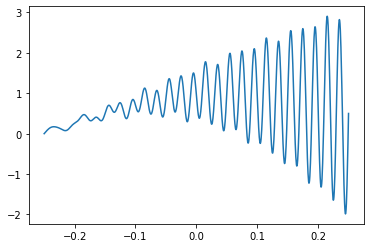

In [214]:
# x = np.linspace(-0.5, 0.5, 500)
# x = np.linspace(0, 0.5, 500)
x = np.linspace(0, 0.5, 1000)
# x = np.linspace(0, 0.5, 10000)
y = np.sin(2*np.pi*x/1.2) + np.sin(2*np.pi*x*50)/10 * x**2*100 + np.sin(2*np.pi*x*20)/10

x = x[:,np.newaxis]-0.25
y = y[:,np.newaxis]

xtrain = x[::2]
xval = x[1::2]

ytrain = y[::2]
yval = y[1::2]

plt.plot(x, y)

In [793]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    FourierFeatureProjection(gaussian_projection = 20, gaussian_scale = 6),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1),
])

In [794]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [795]:
history = model.fit(xtrain, ytrain, epochs=1000, verbose=0, batch_size=250, validation_data=(xval, yval))

2022-06-20 12:24:34.041593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 12:24:34.159282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


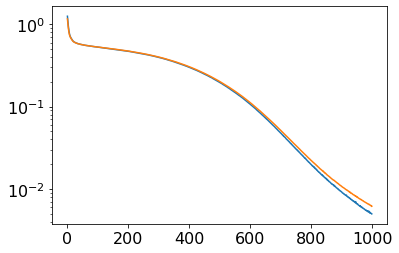

In [796]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')

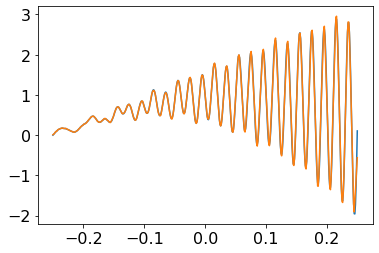

In [797]:
plt.plot(xtrain, ytrain)
plt.plot(xtrain, model(xtrain))

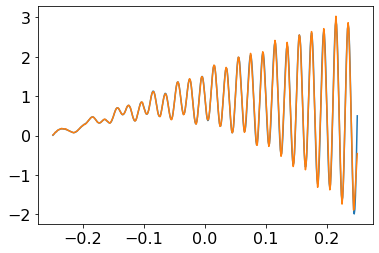

In [798]:
plt.plot(xval, yval)
plt.plot(xval, model(xval))

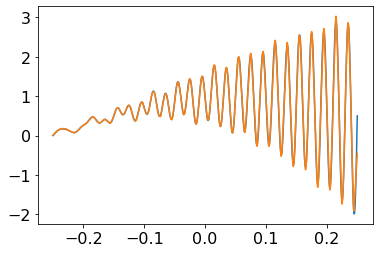

In [799]:
plt.plot(x, y)
plt.plot(x, model(x))

# gaussian

- https://arxiv.org/abs/2204.05735: Gaussian activations without RFF?
- https://github.com/laura-a-n-n/tf-garf

In [31]:
def gaussian_activation(x, c=0, sigma=0.1):
    return tf.math.exp(-(x-c)**2 / (2*sigma**2))    

In [141]:
# Gaussian Activation with tunable scale
class GaussianLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(GaussianLayer, self).__init__()
        self.c=0

    def build(self, input_shape):
        # sigma_initializer = tf.keras.initializers.RandomUniform(-1,1)
        # sigma_initializer = tf.keras.initializers.RandomNormal(0, 0.3)
        sigma_initializer=None
        self.sigma = self.add_weight(
            "sigma",
            shape=[int(input_shape[-1]),],
            initializer=sigma_initializer)

    def call(self, inputs):
        return tf.math.exp(-(inputs-self.c)**2 / (2*self.sigma**2))


In [142]:
layer = GaussianLayer()

In [143]:
test_inputs = tf.convert_to_tensor(np.linspace(1, 5, 5)[:, np.newaxis])

In [144]:
test_inputs

<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[1.],
       [2.],
       [3.],
       [4.],
       [5.]])>

In [147]:
layer(test_inputs)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[3.0841857e-01],
       [9.0482011e-03],
       [2.5250276e-05],
       [6.7026891e-09],
       [1.6924488e-13]], dtype=float32)>

In [148]:
layer.get_weights()

[array([-0.65196824], dtype=float32)]

In [234]:
# kernel_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.1)

# default
kernel_initializer = 'glorot_uniform'

model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    FourierFeatureProjection(gaussian_projection = 20, gaussian_scale = 6),
    # FourierFeatureProjection(gaussian_projection = 20*4, gaussian_scale = 6*2),
    # FourierFeatureProjection(gaussian_projection = 40*2, gaussian_scale = 20),
    # FourierFeatureProjection(gaussian_projection = 40*4, gaussian_scale = 20*2),
    # tf.keras.layers.Dense(256),
    # GaussianLayer(),
    # tf.keras.layers.Dense(256),
    # GaussianLayer(),
    tf.keras.layers.Dense(256, activation=gaussian_activation, kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(256, activation=gaussian_activation, kernel_initializer=kernel_initializer),
    # tf.keras.layers.Dense(256, activation=gaussian_activation, kernel_initializer=kernel_initializer),
    # tf.keras.layers.Dense(256, activation=gaussian_activation, kernel_initializer=kernel_initializer),
    # tf.keras.layers.Dense(256, activation=gaussian_activation, kernel_initializer=kernel_initializer),
    # tf.keras.layers.Dense(256, activation=gaussian_activation, kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1),
])

In [235]:
# gaussian activations required a smaller learning rate as the loss was jumpy
model_2.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))

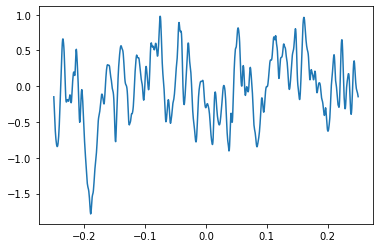

In [236]:
plt.plot(x, model_2(x))

In [237]:
%%time
# history_2 = model_2.fit(xtrain, ytrain, epochs=300, verbose=0, batch_size=250, validation_data=(xval, yval))
history_2 = model_2.fit(xtrain, ytrain, epochs=1000, verbose=0, batch_size=250, validation_data=(xval, yval))

2022-06-20 18:40:39.989941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 18:40:40.110166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 17.7 s, sys: 9.6 s, total: 27.3 s
Wall time: 24.5 s


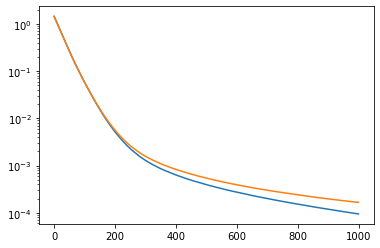

In [238]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.yscale('log')

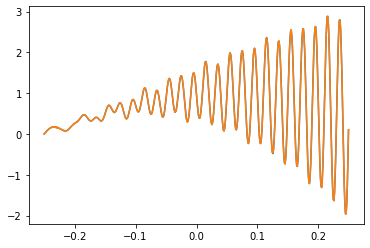

In [231]:
plt.plot(xtrain, ytrain)
plt.plot(xtrain, model_2(xtrain))

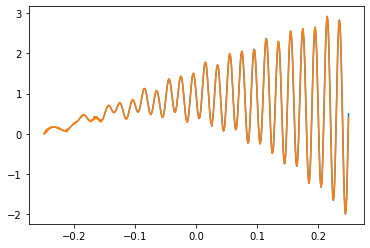

In [232]:
plt.plot(xval, yval)
plt.plot(xval, model_2(xval))

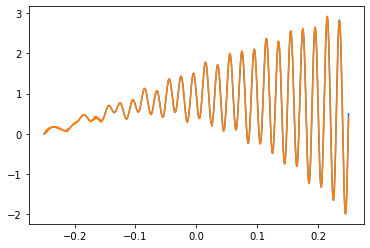

In [233]:
plt.plot(x, y)
plt.plot(x, model_2(x))

# compare

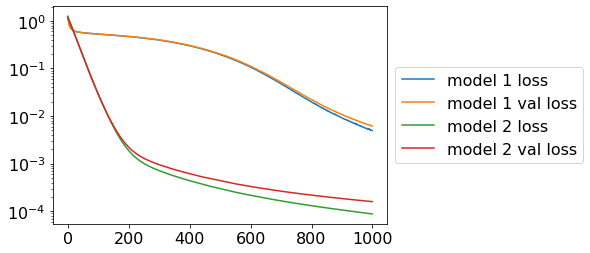

In [821]:
plt.plot(history.history['loss'], label='model 1 loss')
plt.plot(history.history['val_loss'], label='model 1 val loss')
plt.plot(history_2.history['loss'], label='model 2 loss')
plt.plot(history_2.history['val_loss'], label='model 2 val loss')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

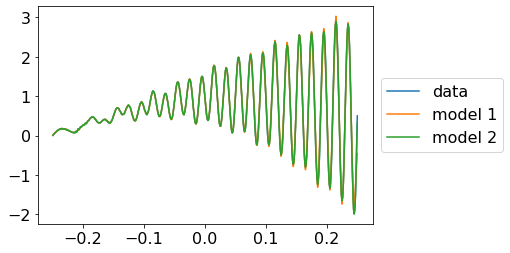

In [822]:
plt.plot(xval, yval, label='data')
plt.plot(xval, model(xval), label='model 1')
plt.plot(xval, model_2(xval), label='model 2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

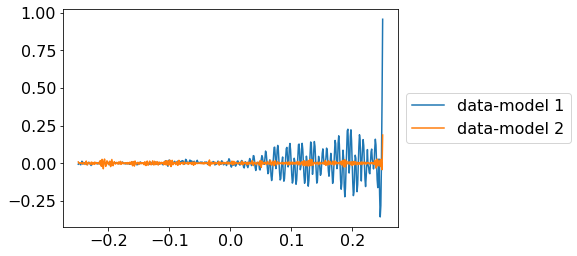

In [823]:
plt.plot(xval, yval-model(xval), label='data-model 1')
plt.plot(xval, yval-model_2(xval), label='data-model 2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

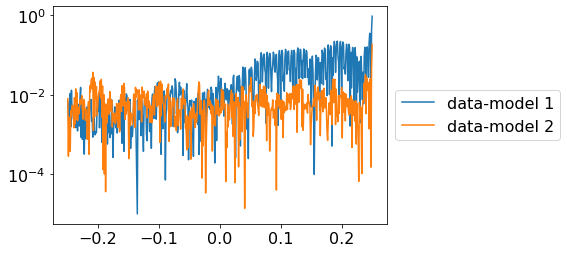

In [824]:
plt.plot(xval, np.abs(yval-model(xval)), label='data-model 1')
plt.plot(xval, np.abs(yval-model_2(xval)), label='data-model 2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')